In [1]:
from tree_sitter import Language, Parser
import networkx as nx
import matplotlib.pyplot as plt
from regraph import plot_graph, plot_instance, plot_rule, NXGraph, Rule
from builder_functions.graph_builder import bfs_tree_traverser
from test_scripts import Python, R
from parser_test import parse
from builder_functions.pattern_builder import clear_graph, print_graph, remove_everything_else, rewrite_graph, print_graph, connect_parent_and_children, create_simple_pattern, remove_nodes, get_ids, add_attrs_from_patterns, remove_descendants
import json

In [23]:
code = Python.code_3

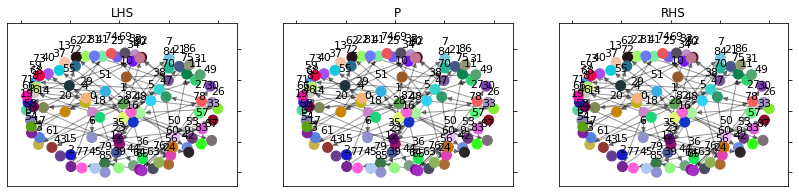

In [24]:
language = "python"
parsed_ast = parse(language, code)
G = bfs_tree_traverser(parsed_ast)
parsed_json = G.to_json()
rule = Rule.from_transform(G)
plot_rule(rule)

--------------------------------------

<h2>Graph Simplification by Node Generalization</h2>

In [4]:
print_graph(G)

List of nodes: 
	 0 {'type': {'module'}, 'text': {b'from sklearn.preprocessing import StandardScaler, OneHotEncoder\n        import matplotlib.pyplot as plt\n        import numpy as np\n        import lib\n        \n        def perform_bernoulli_trials(n, p):\n        \n            # Initialize number of successes: n_success\n            n_success = 0\n            return n_success\n            \n        print("Python is great!")\n        \n        np.ndarray(size=(5,5))\n        \n        x = 5 * 3\n        '}}
	 1 {'type': {'import_from_statement'}, 'text': {b'from sklearn.preprocessing import StandardScaler, OneHotEncoder'}, 'parent_id': {0}}
	 2 {'type': {'import_statement'}, 'text': {b'import matplotlib.pyplot as plt'}, 'parent_id': {0}}
	 3 {'type': {'import_statement'}, 'text': {b'import numpy as np'}, 'parent_id': {0}}
	 4 {'type': {'import_statement'}, 'text': {b'import lib'}, 'parent_id': {0}}
	 5 {'type': {'function_definition'}, 'text': {b'def perform_bernoulli_trials(n, p):

In [5]:
def remove_descendants2(node_type, instances, rule):
    for ins in instances:
        node_id = ins[node_type]
        desc = G.descendants(node_id)
        for id in list(desc):
            rule.inject_remove_node(id)
    return rule


# creates a subgraph of the nodes given in ids, searches for their descendants that match the different given patterns
# and adds the text attribute of nodes that match those patterns as an attribute to the ascendant node
def add_attrs_from_patterns2(ids, patterns, is_import, G):

    for id in ids:
        subg_nodes = list(G.descendants(id)) if is_import else list(G.successors(id))
        subg_nodes.append(id)
        subgraph = G.generate_subgraph(G, subg_nodes)
        
        for patt in patterns:
            instances = subgraph.find_matching(patt[1])
            
            if len(instances) > 0:
                sub_id = get_ids(patt[0], instances)

                G.add_node_attrs(id, attrs={patt[0] : subgraph.get_node(sub_id[0])["text"]})

----------

<h3>Approach: Specify "relevant" nodes and delete the rest</h3>

<b>Complex patterns</b>

In [24]:
#import_statement complex pattern (with alias)
pattern = NXGraph()
pattern.add_nodes_from(["import_statement", "aliased_import", "library", "alias"])
pattern.add_node_attrs("import_statement", {"type": "import_statement"})
pattern.add_node_attrs("aliased_import", {"type": "aliased_import"})
pattern.add_node_attrs("library", {"type": "dotted_name"})
pattern.add_node_attrs("alias", {"type": "identifier"})
pattern.add_edges_from([("aliased_import", "library"), ("aliased_import", "alias"), ("import_statement", "aliased_import")])

In [7]:
#import_statement complex pattern (without alias)
pattern = NXGraph()
pattern.add_nodes_from(["import_statement", "library"])
pattern.add_node_attrs("import_statement", {"type": "import_statement"})
pattern.add_node_attrs("library", {"type": "dotted_name"})
pattern.add_edges_from([("import_statement", "library")])

In [47]:
#3 variables
# index_to_change
# type_to_change
# name_to_change_to
parent_type = "import_from_statement"
type_to_change = "dotted_name"
index_to_change = 0

#change_name pattern
pattern = NXGraph()
pattern.add_nodes_from(["import_from_statement", "dotted_name"])
pattern.add_node_attrs("import_from_statement", {"type": "import_from_statement"})
pattern.add_node_attrs("dotted_name", {"type": "dotted_name"})
pattern.add_edges_from([("import_from_statement", "dotted_name")])

instances = G.find_matching(pattern)

<b>Create patterns to select the "relevant" nodes:</b>

In [46]:
language = "python"
parsed_ast = parse(language, code)
G = bfs_tree_traverser(parsed_ast)

In [37]:
#import_from_statement complex pattern 
pattern = NXGraph()
pattern.add_nodes_from(["import_from_statement", "import_library", "imported", "identifier1", "identifier2"])
pattern.add_node_attrs("import_from_statement", {"type": "import_from_statement"})
pattern.add_node_attrs("import_library", {"type": "dotted_name"})
pattern.add_node_attrs("imported", {"type": "dotted_name"})
pattern.add_node_attrs("identifier1", {"type": "identifier"})
pattern.add_node_attrs("identifier2", {"type": "identifier"})
pattern.add_edges_from([("import_from_statement", "import_library"), ("import_from_statement", "imported"), ("import_library", "identifier1"), ("imported", "identifier2")])

In [57]:
pattern1 = create_simple_pattern("import", "import_statement")
pattern2 = create_simple_pattern("function_def", "function_definition")
pattern3 = create_simple_pattern("function_call", "call")
pattern4 = create_simple_pattern("var_assignment", "assignment")
pattern5 = create_simple_pattern("first_node", "module")
pattern6 = create_simple_pattern("code_block", "block")
pattern7 = create_simple_pattern("if", "if_statement")
pattern8 = create_simple_pattern("for", "for_statement")
pattern9 = create_simple_pattern("expr_statement", "expression_statement")

In [58]:
all_ids = []

<b>Import statements:</b><br>

In [59]:
# pattern matching of import_statements
instances = G.find_matching(pattern1)
this_ids = get_ids("import", instances)
all_ids += this_ids

patterns = []

# pattern to get the library name
patt = create_simple_pattern("library", "dotted_name")
patterns.append(("library", patt))

# pattern to get the alias
patt = create_simple_pattern("alias", "identifier")
patterns.append(("alias", patt))

add_attrs_from_patterns2(this_ids, patterns, True)

<p style="color:red;"><b>Missing cases when import statements are called using "from lib import x".</b></p>

<b>Functions definitions:</b>

In [60]:
# pattern matching of function_definition
instances = G.find_matching(pattern2)
this_ids = get_ids("function_def", instances)
all_ids += this_ids

patterns = []

# pattern to get the function name
patt = create_simple_pattern("function", "identifier")
patterns.append(("function", patt))

# pattern to get the parameters
patt = create_simple_pattern("parameters", "parameters")
patterns.append(("parameters", patt))

add_attrs_from_patterns2(this_ids, patterns, False)

<p style="color:red;"><b>Add return statements?</b></p>

<b>Functions calls:</b>

In [61]:
# pattern matching of function call
instances = G.find_matching(pattern3)
this_ids = get_ids("function_call", instances)
all_ids += this_ids

patterns = []

# pattern to get the function arguments
patt = create_simple_pattern("arguments", "argument_list")
patterns.append(("arguments", patt))

add_attrs_from_patterns2(this_ids, patterns, False)

<b>Code blocks (connector node):</b>

In [62]:
instances = G.find_matching(pattern6)
this_ids = get_ids("code_block", instances)
#all_ids += this_ids

rule = connect_parent_and_children(G, this_ids, rule)

# for id in this_ids:
#     print(id)
#     rule.inject_remove_node(id)

<b>Expression statements (connector node):</b>

In [63]:
instances = G.find_matching(pattern9)
this_ids = get_ids("expr_statement", instances)
#all_ids += this_ids

rule = connect_parent_and_children(G, this_ids, rule)

# for id in this_ids:
#     print(id)
#     rule.inject_remove_node(id)

<p style="color:red;"><b>Solve issue where expression statements end up being disconnected from the rest of the graph if their parent is an already removed "block" node</b></p>

<b>To do:</b>
<ul>
    <li>for loops</li>
    <li>while loops</li>
    <li>variable assignments</li>
    <li>if statements</li>
    <li>else if and else statements</li>
</ul>

In [64]:
instances = G.find_matching(pattern4)
this_ids = get_ids("var_assignment", instances)
all_ids += this_ids

instances = G.find_matching(pattern5)
this_ids = get_ids("first_node", instances)
all_ids += this_ids

instances = G.find_matching(pattern7)
this_ids = get_ids("if", instances)
all_ids += this_ids

instances = G.find_matching(pattern8)
this_ids = get_ids("for", instances)
all_ids += this_ids


<p style="color:red;"><b>We need to find more types of nodes and create patterns for each of them.</b></p>

<p style="color:red;"><b>We need to test if what we have also works with R.</b></p>

<b>Delete all nodes that are not "relevant":</b>

In [65]:
rule = remove_everything_else(all_ids, rule, len(parsed_json["nodes"]))

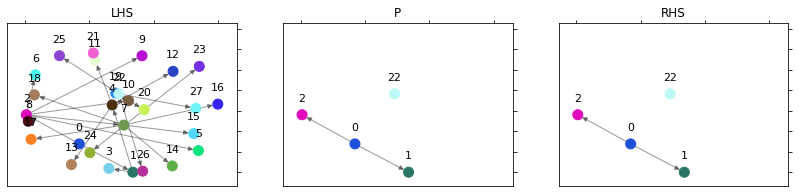

In [66]:
plot_rule(rule)

In [71]:
G.get_node(1)

{'type': {'import_statement'},
 'text': {b'import numpy as np'},
 'parent_id': {0},
 'library': {b'numpy'},
 'alias': {b'np'}}

--------

<h2>Testing pattern_builder.py</h2>

In [1]:
from tree_sitter import Language, Parser
import networkx as nx
import matplotlib.pyplot as plt
from regraph import plot_graph, plot_instance, plot_rule, NXGraph, Rule
from builder_functions.graph_builder import bfs_tree_traverser
from test_scripts import Python, R
from parser_test import parse
from builder_functions.pattern_builder import clear_graph, rewrite_graph, print_graph, create_simple_pattern, remove_nodes, get_ids, add_attrs_from_patterns, remove_descendants
import json

In [75]:
language = "python"
tree_sitter = parse(language, Python.code_3)
nxgraph = bfs_tree_traverser(tree_sitter)

In [18]:
def clear_graph2(G):
    # create rule
    rule = Rule.from_transform(G)

    # read json file
    f = open('graph_clearing_patterns.json', "r")
    json_data = json.loads(f.read())

#     # handle redundancies
#     redundant_patterns = []
#     for key in json_data["redundancies"]:
#         value = json_data["redundancies"][key]
#         pattern = create_simple_pattern(key, value)
#         redundant_patterns.append(pattern)
#     i = 0
#     redundant_ids = []
#     for pattern in redundant_patterns:
#         instances = G.find_matching(pattern)
#         if len(instances) != 0:
#             pattern_name = list(redundant_patterns[i]._graph.nodes._nodes)[0]
#             redundant_id = get_ids(pattern_name, instances)
#             redundant_ids += redundant_id
#         i += 1
#     remove_nodes(G, redundant_ids)

    # handle nodes with descendants that contain necessary attributes
    for node in json_data["nodes_with_descendants"]:
        # find parent node
        parent_pattern = create_simple_pattern(node, node)
        instances = G.find_matching(parent_pattern)

        # get ids of all parent occurrences in the graph
        if len(instances) != 0:
            parent_type = list(parent_pattern._graph.nodes._nodes)[0]
            # print(parent_type)
            parent_ids = get_ids(parent_type, instances)

            # find its children names in json
            descendants_patterns = []
            for descendant_node in json_data["nodes_with_descendants"][node]:
                attr_name = json_data["nodes_with_descendants"][node][descendant_node]
                descendant_pattern = create_simple_pattern(attr_name, descendant_node)
                descendants_patterns.append((attr_name, descendant_pattern))

            is_import = False
            if node == "import_statement" or node == "expression_statement" or node == "import_from_statement":
                is_import = True
            
            # get attributes of children
            add_attrs_from_patterns2(parent_ids, descendants_patterns, is_import, G)

            # clear descendants
            remove_descendants(G, parent_type, instances, rule)

    # handle simple nodes
    for node in json_data["simple_nodes"]:
        pattern = create_simple_pattern(json_data["simple_nodes"][node], json_data["simple_nodes"][node])
        instances = G.find_matching(pattern)
        if len(instances) != 0:
            pattern_type = list(pattern._graph.nodes._nodes)[0]
            remove_descendants(G, pattern_type, instances, rule)

    # handle comments
    for node in json_data["nodes_to_completely_remove"]:
        patterns_to_remove = create_simple_pattern(node, node)
        instances = G.find_matching(patterns_to_remove)
        if len(instances) != 0:
            node_type = list(patterns_to_remove._graph.nodes._nodes)[0]
            node_ids = get_ids(node_type, instances)
            remove_nodes(G, node_ids)

    return G

In [19]:
G = clear_graph2(nxgraph)

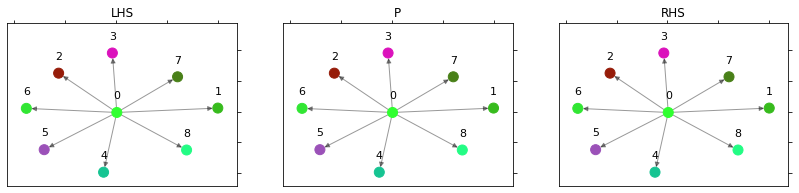

In [20]:
rule = Rule.from_transform(G)
plot_rule(rule)

In [24]:
G.get_node(4)

{'type': {'import_statement'},
 'text': {b'import lib'},
 'parent_id': {0},
 'library': {b'lib'},
 'alias': {b'lib'}}

----------------------------------

<h2>Patterns to rename node types</h2>

In [7]:
from tree_sitter import Language, Parser
import networkx as nx
import matplotlib.pyplot as plt
from regraph import plot_graph, plot_instance, plot_rule, NXGraph, Rule
from builder_functions.graph_builder import bfs_tree_traverser
from test_scripts import Python, R
from parser_test import parse
from builder_functions.pattern_builder import rename_graph_types, print_nodes, clear_graph, rewrite_graph, print_graph, create_simple_pattern, remove_nodes, get_ids, add_attrs_from_patterns, remove_descendants
import json

In [18]:
language = "python"
parsed_ast = parse(language, Python.code_6)
G = bfs_tree_traverser(parsed_ast)

In [19]:
changed_nodes = rename_graph_types(G)

In [20]:
print_nodes(G, changed_nodes)

{'type': {'function'}, 'text': {b'sc_Y.fit_transform'}, 'parent_id': {193}}
{'type': {'caller_function'}, 'text': {b'regressor.predict'}, 'parent_id': {94}}
{'type': {'function'}, 'text': {b'y.reshape'}, 'parent_id': {276}}
{'type': {'caller_function'}, 'text': {b'sc_Y.inverse_transform'}, 'parent_id': {97}}
{'type': {'import_path'}, 'text': {b'sklearn.preprocessing'}, 'parent_id': {7}}
{'type': {'imported'}, 'text': {b'StandardScaler'}, 'parent_id': {7}}
{'type': {'import_path'}, 'text': {b'sklearn.svm'}, 'parent_id': {13}}
{'type': {'imported'}, 'text': {b'SVR'}, 'parent_id': {13}}
{'type': {'import_path'}, 'text': {b'pandas'}, 'parent_id': {21}}
{'type': {'alias'}, 'text': {b'pd'}, 'parent_id': {21}}
{'type': {'import_path'}, 'text': {b'matplotlib.pyplot'}, 'parent_id': {23}}
{'type': {'alias'}, 'text': {b'plt'}, 'parent_id': {23}}
{'type': {'import_path'}, 'text': {b'numpy'}, 'parent_id': {25}}
{'type': {'alias'}, 'text': {b'np'}, 'parent_id': {25}}
{'type': {'variable_list'}, 'tex

In [21]:
clear_graph(G)

In [22]:
print_graph(G)

List of nodes: 
	 0 {'type': {'module'}, 'text': {b"import pandas as pd\n        import matplotlib.pyplot as plt\n        import numpy as np\n        dataset = pd.read_csv('../input/Position_Salaries.csv')\n        X = dataset.iloc[:, 1:2].values\n        y = dataset.iloc[:, -1].values\n        from sklearn.preprocessing import StandardScaler\n        sc_X = StandardScaler()\n        sc_Y = StandardScaler()\n        X = sc_X.fit_transform(X)\n        y = np.squeeze(sc_Y.fit_transform(y.reshape(-1, 1)))\n        # the feature scaling will be done to both X and Y and still Y will remain the Vector\n        from sklearn.svm import SVR\n        regressor = SVR(kernel = 'rbf')\n        regressor.fit(X, y)\n        SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,\n            gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,\n            tol=0.001, verbose=False)\n        y_pred = regressor.predict([[6.5]])\n        y_pred = sc_Y.inverse_transform(y_pred)\n     